# 👋 Welcome to the tutorial

In this tutorial, we will see how the proposed `SMDL-Attribution` method works.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.chdir("../")

import cv2
import numpy as np
import  matplotlib.pyplot as plt

plt.style.use('seaborn')

from utils import *
import matplotlib

from models.submodular_cub_v2 import CubSubModularExplanationV2
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop,
                                  GradCAMPP, Lime, KernelShap, SobolAttributionMethod, HsicAttributionMethod)

matplotlib.get_cachedir()
plt.rc('font', family="Times New Roman")

from sklearn import metrics
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

/tmp/ipykernel_3130571/669884613.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-05 02:20:48.351560: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 02:20:48.397561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow bina

In [2]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
def SubRegionDivision(image, mode="slico"):
    element_sets_V = []
    if mode == "slico":
        slic = cv2.ximgproc.createSuperpixelSLIC(image, region_size=30, ruler = 20.0) 
        slic.iterate(20)     # The number of iterations, the larger the better the effect
        label_slic = slic.getLabels()        # Get superpixel label
        number_slic = slic.getNumberOfSuperpixels()  # Get the number of superpixels

        for i in range(number_slic):
            img_copp = image.copy()
            img_copp = img_copp * (label_slic == i)[:,:, np.newaxis]
            element_sets_V.append(img_copp)
    elif mode == "seeds":
        seeds = cv2.ximgproc.createSuperpixelSEEDS(image.shape[1], image.shape[0], image.shape[2], num_superpixels=50, num_levels=3)
        seeds.iterate(image,10)  # The input image size must be the same as the initialization shape and the number of iterations is 10
        label_seeds = seeds.getLabels()
        number_seeds = seeds.getNumberOfSuperpixels()

        for i in range(number_seeds):
            img_copp = image.copy()
            img_copp = img_copp * (label_seeds == i)[:,:, np.newaxis]
            element_sets_V.append(img_copp)
    return element_sets_V

In [4]:
smdl = CubSubModularExplanationV2(
        cfg_path="configs/cub/submodular_cfg_cub_tf-resnet-v2.json", 
        k=50, 
        lambda1=1, 
        lambda2=1, 
        lambda3=1, 
        lambda4=1)

/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Success load pre-trained uncertainty model ckpt/pytorch_model/cub-resnet101-edl.pth
Success load pre-trained bird recognition model ckpt/keras_model/cub-resnet101.h5


In [5]:
image_path = "examples/Crested_Auklet_0059_794929.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))

## Visualization

In [6]:
def visualization(image, submodular_image_set, saved_json_file):
    insertion_ours_images = []
    deletion_ours_images = []

    insertion_image = submodular_image_set[0]
    insertion_ours_images.append(insertion_image)
    deletion_ours_images.append(image - insertion_image)
    for smdl_sub_mask in submodular_image_set[1:]:
        insertion_image = insertion_image.copy() + smdl_sub_mask
        insertion_ours_images.append(insertion_image)
        deletion_ours_images.append(image - insertion_image)

    insertion_ours_images_input_results = np.array(saved_json_file["consistency_score"])

    ours_best_index = np.argmax(insertion_ours_images_input_results)
    x = [(insertion_ours_image.sum(-1)!=0).sum() / (image.shape[0] * image.shape[1]) for insertion_ours_image in insertion_ours_images]
    i = len(x)

    fig, [ax2, ax3] = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]}, figsize=(24,8))
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax2.set_title('Ours', fontsize=54)
    ax2.set_facecolor('white')

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    plt.title('Insertion', fontsize=54)
    plt.ylabel('Recognition Score', fontsize=44)
    plt.xlabel('Percentage of image revealed', fontsize=44)

    x_ = x[:i]
    ours_y = insertion_ours_images_input_results[:i]
    ax3.plot(x_, ours_y, color='dodgerblue', linewidth=3.5)  # draw curve

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    plt.scatter(x_[-1], ours_y[-1], color='dodgerblue', s=54)  # Plot latest point

    kernel = np.ones((3, 3), dtype=np.uint8)
    plt.plot([x_[ours_best_index], x_[ours_best_index]], [0, 1], color='red', linewidth=3.5)  # 绘制红色曲线

    # Ours
    mask = (image - insertion_ours_images[ours_best_index]).mean(-1)
    mask[mask>0] = 1

    dilate = cv2.dilate(mask, kernel, 3)
    # erosion = cv2.erode(dilate, kernel, iterations=3)
    # dilate = cv2.dilate(erosion, kernel, 2)
    edge = dilate - mask
    # erosion = cv2.erode(dilate, kernel, iterations=1)

    image_debug = image.copy()

    image_debug[mask>0] = image_debug[mask>0] * 0.5
    image_debug[edge>0] = np.array([0,0,255])
    ax2.imshow(image_debug[...,::-1])

    auc = metrics.auc(x, insertion_ours_images_input_results)

    print("Highest confidence: {}\nfinal confidence: {}\nInsertion AUC: {}".format(insertion_ours_images_input_results.max(), insertion_ours_images_input_results[-1], auc))

### SLICO

2023-12-05 02:21:12.045036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-12-05 02:21:12.834939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Highest confidence: 0.9521416425704956
final confidence: 0.7259629368782043
Insertion AUC: 0.7603823737350022


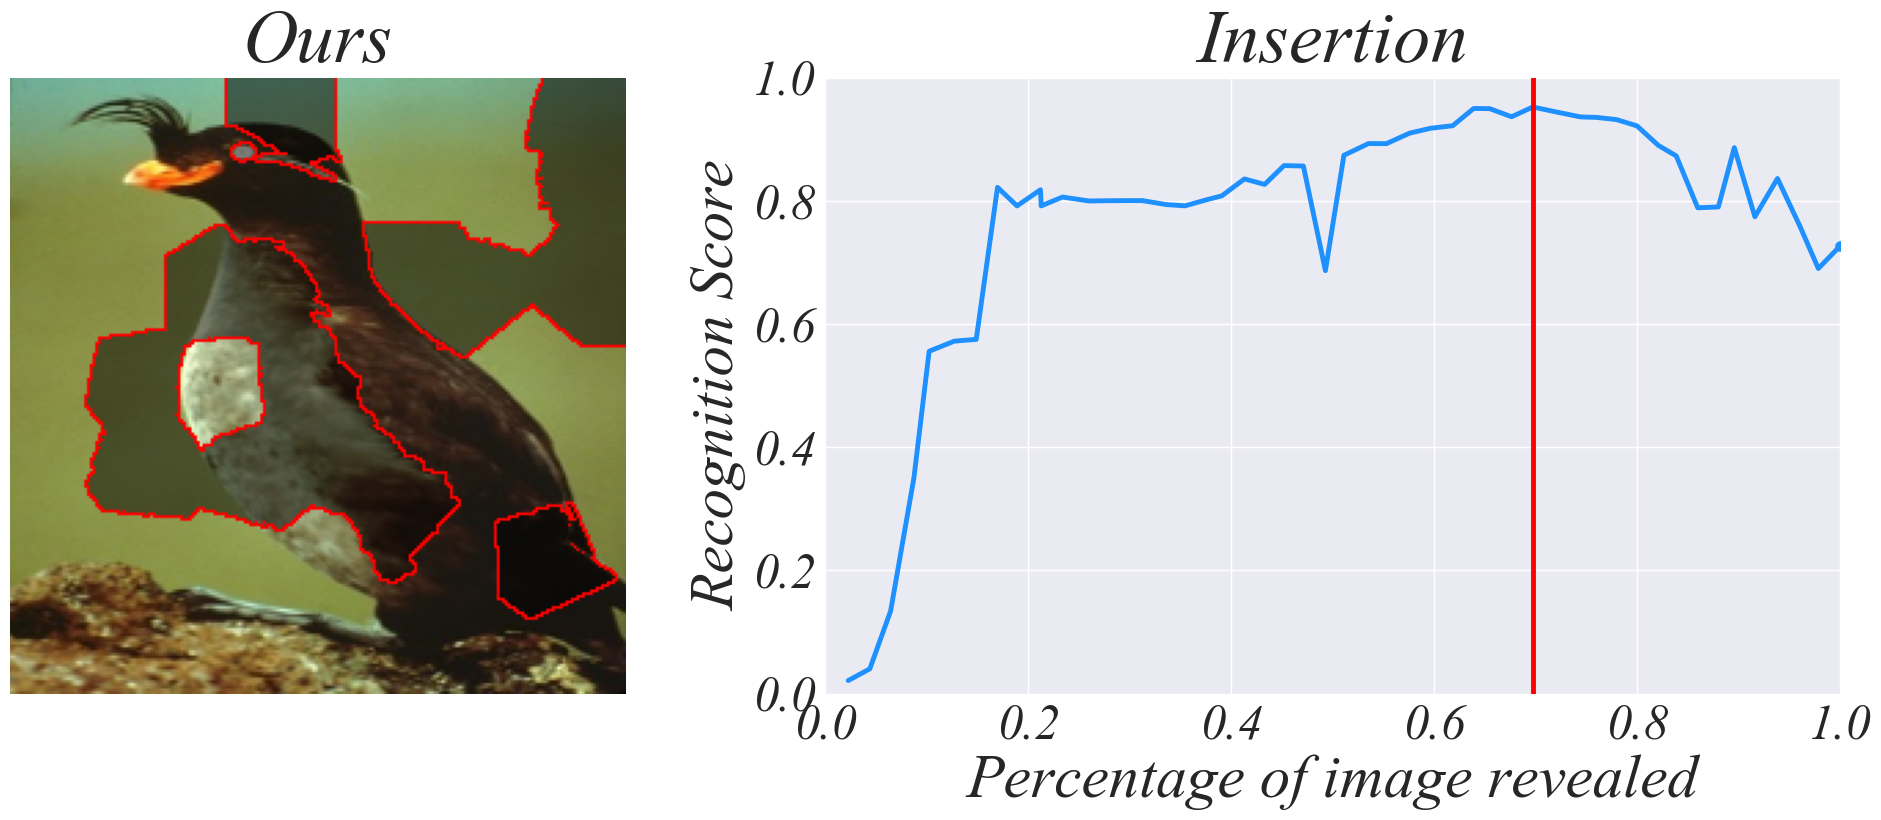

In [7]:
element_sets_V = SubRegionDivision(image, mode="slico")
smdl.k = len(element_sets_V)
submodular_image, submodular_image_set, saved_json_file = smdl(element_sets_V)
visualization(image, submodular_image_set, saved_json_file)

## Seeds

100%|██████████| 49/49 [00:50<00:00,  1.03s/it]


Highest confidence: 0.991811990737915
final confidence: 0.7260107398033142
Insertion AUC: 0.8862345040142827


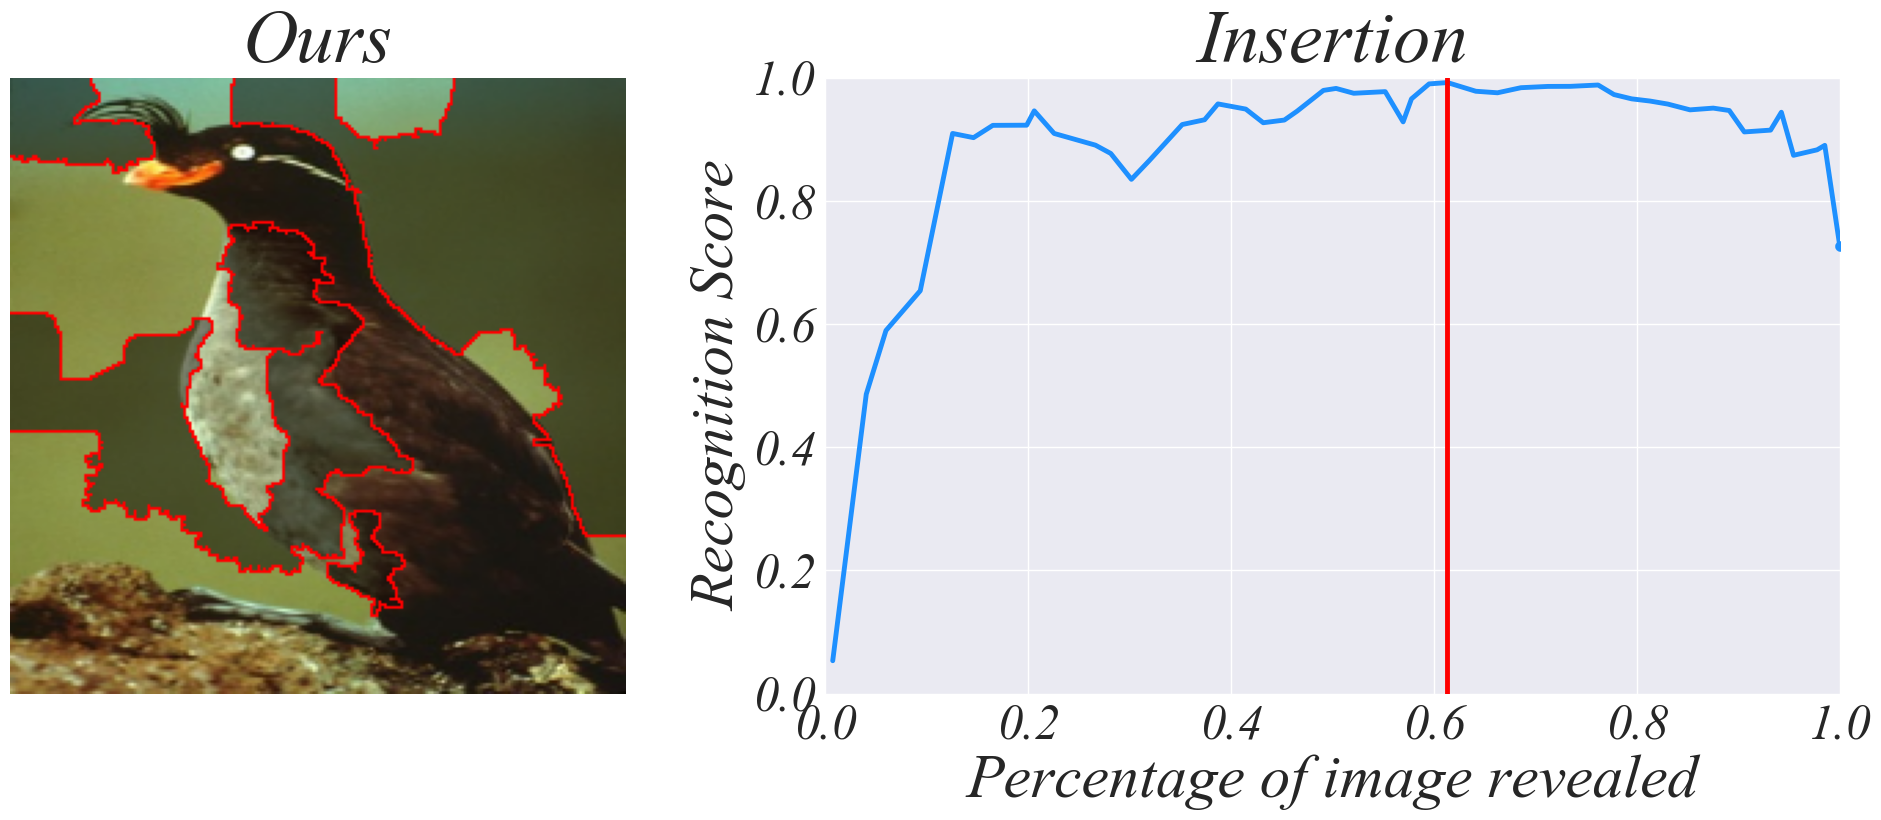

In [8]:
element_sets_V = SubRegionDivision(image, mode="seeds")
smdl.k = len(element_sets_V)
submodular_image, submodular_image_set, saved_json_file = smdl(element_sets_V)
visualization(image, submodular_image_set, saved_json_file)

## ICLR 24 division method: Prior Saliency Map+Patch

In [9]:
import tensorflow as tf
from keras.models import load_model
from keras import backend as K

In [10]:
model = load_model(smdl.cfg["recognition_model"]["model_path"])
input_img = smdl.convert_prepare_image(image)
labels_ohe = np.array([tf.one_hot(model(np.array([input_img])).numpy().argmax(), smdl.cfg["recognition_model"]["num_classes"])])
explainer = HsicAttributionMethod(model)
explanations = explainer(np.array([input_img]), labels_ohe)
del model
del explainer
K.clear_session()

2023-11-28 19:58:36.510244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [500,8,8,1]
	 [[{{node Placeholder/_0}}]]


In [11]:
def partition_by_mulit_grad(image, explanation_mask, grad_size = 10, grad_num_per_set = 4):
    """
    Divide the image into grad_size x grad_size areas, divide according to eplanation_mask, each division has grad_num_per_set grads.
    """
    partition_number = int(grad_size * grad_size / grad_num_per_set)
    # pixel_length_per_grad = int(image.shape[0] / grad_size)

    components_image_list = []
    pool_z = cv2.resize(explanation_mask, (grad_size, grad_size))

    pool_z_flatten = pool_z.flatten()
    index = np.argsort(- pool_z_flatten)     # From high to low

    for i in range(partition_number):
        binary_mask = np.zeros_like(index)
        binary_mask[index[i*grad_num_per_set : (i+1)*grad_num_per_set]] = 1
        binary_mask = binary_mask.reshape((grad_size, grad_size, 1))
        binary_mask = cv2.resize(
            binary_mask, (image.shape[0],image.shape[1]), interpolation=cv2.INTER_NEAREST)

        components_image_list.append(
            (image * binary_mask[:, :, np.newaxis]).astype(np.uint8)
        )
        
    return components_image_list

100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


Highest confidence: 0.970952033996582
final confidence: 0.7260107398033142
Insertion AUC: 0.7236622742419764


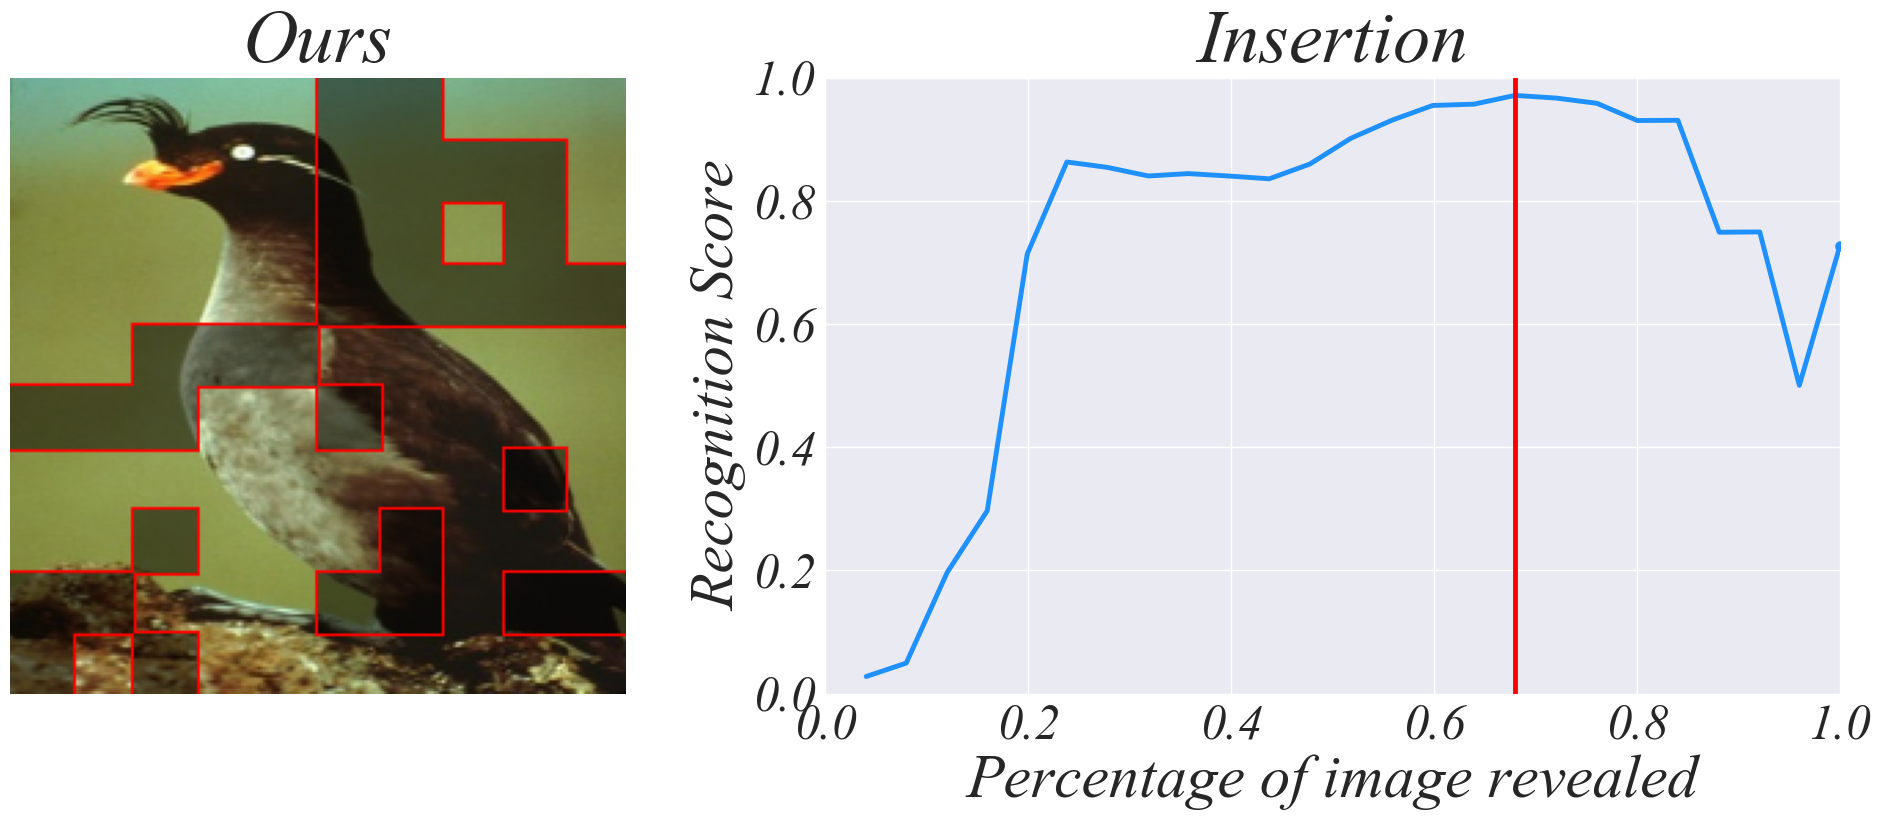

In [12]:
element_sets_V = partition_by_mulit_grad(image, explanations[0])
smdl.k = len(element_sets_V)
submodular_image, submodular_image_set, saved_json_file = smdl(element_sets_V)
visualization(image, submodular_image_set, saved_json_file)

## Segment Anything

In [7]:
image_path = "examples/Crested_Auklet_0059_794929.jpg"
image = cv2.imread(image_path)
# image = cv2.resize(image, (224, 224))
sam = sam_model_registry["vit_h"](checkpoint="ckpt/pytorch_model/sam_vit_h_4b8939.pth")
# sam.to("cuda")
mask_generator = SamAutomaticMaskGenerator(sam, stability_score_thresh=0.2)
# This use cpu, maybe a little late.
masks = mask_generator.generate(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [8]:
def processing_sam_concepts(sam_masks, image):
    """
    Process the regions divided by SAM to prevent intersection of sub-regions.
        sam_mask: Masks generated by Segment Anything Model
    """
    num = len(sam_masks)
    mask_sets_V = [mask['segmentation'].astype(np.uint8) for mask in sam_masks]

    for i in range(num-1):
        for j in range(i+1, num):
            intersection_region = (mask_sets_V[i] + mask_sets_V[j] == 2).astype(np.uint8)
            # no intersection region
            if intersection_region.sum() == 0:
                continue
            else:
                proportion_1 = intersection_region.sum() / mask_sets_V[i].sum()
                proportion_2 = intersection_region.sum() / mask_sets_V[j].sum()
                if proportion_1 > proportion_2:
                    mask_sets_V[j] -= intersection_region
                else:
                    mask_sets_V[i] -= intersection_region
    element_sets_V = []
    for mask in mask_sets_V:
        if mask.mean() > 0.0005:
            element_sets_V.append(image * mask[:,:,np.newaxis])
    element_sets_V.append(image - np.array(element_sets_V).sum(0).astype(np.uint8))

    return element_sets_V

Highest confidence: 0.9523458480834961
final confidence: 0.7263192534446716
Insertion AUC: 0.6803439567641302


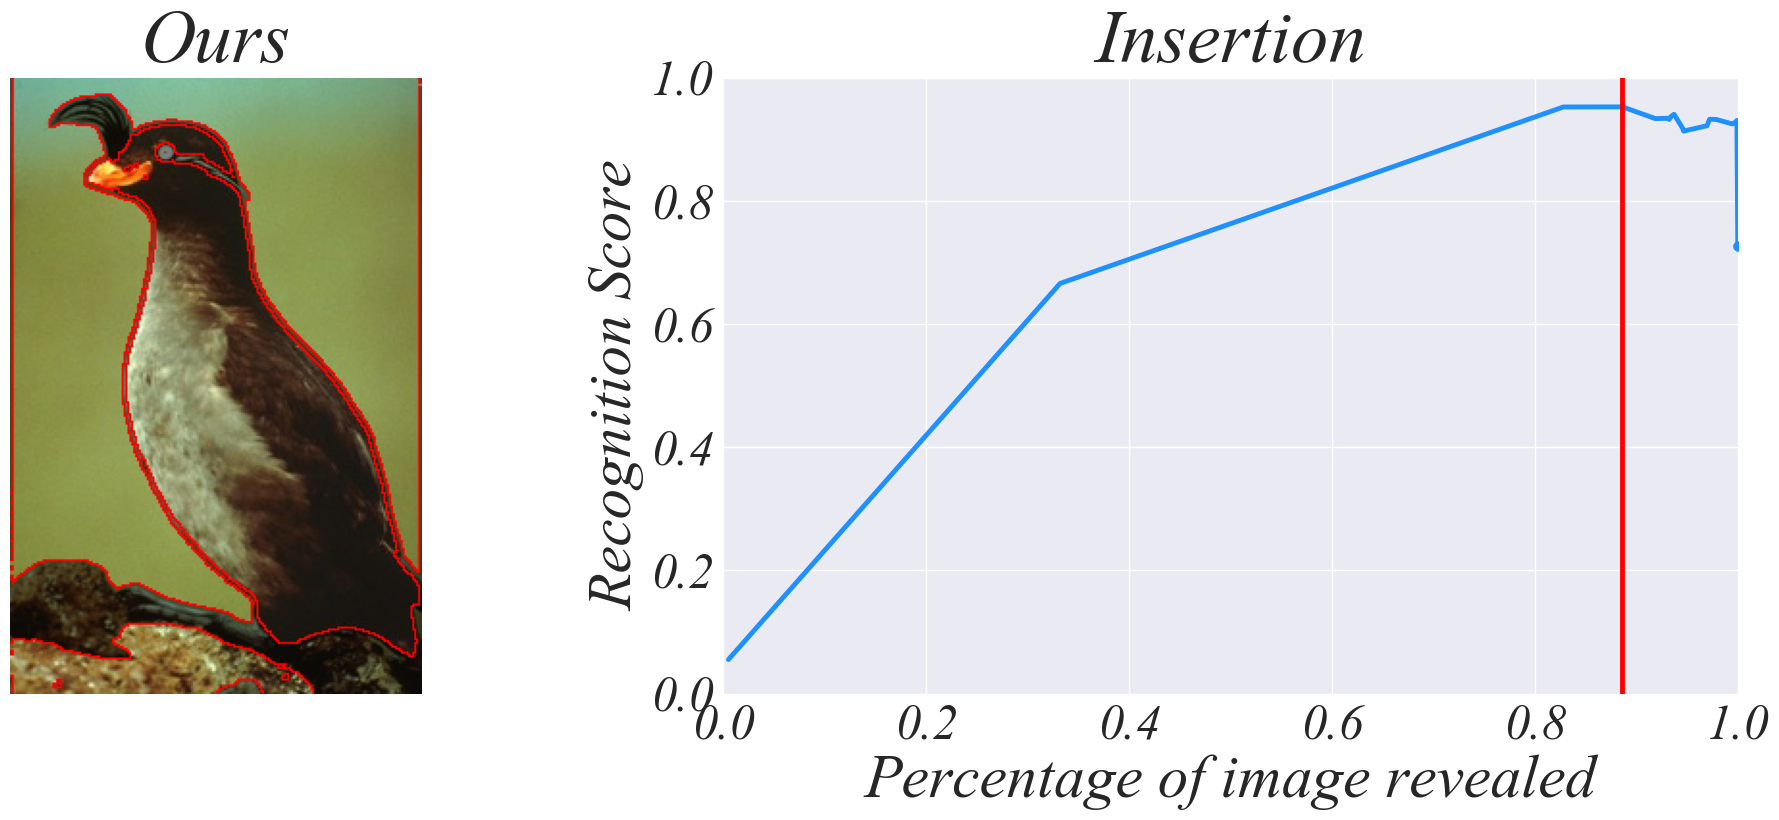

In [18]:
element_sets_V = processing_sam_concepts(masks, image)
smdl.k = len(element_sets_V)
submodular_image, submodular_image_set, saved_json_file = smdl(element_sets_V)
visualization(image, submodular_image_set, saved_json_file)